In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm_notebook as tqdm
import os, glob, json
import config as cfg
from IPython.display import display
from ipywidgets import widgets, Layout
from module.cluster import VAE_Cluster
from module.vmt import VMT, TemplateD
from module.vae import GaussianKLLoss
from dataset import KKDayUser, seq_collate
from constant import Constants
from utils import get_fixed_temperature, get_losses
from sklearn.cluster import KMeans
import numpy as np
from tensorboardX import SummaryWriter
from utils import gradient_penalty, str2bool, chunks
from sklearn.manifold import SpectralEmbedding
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
from shutil import copyfile
import pickle
import seaborn as sns
from collections import namedtuple

In [3]:
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [4]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

In [5]:
class Struct:
    def __init__(self, **entries):
        self.__dict__.update(entries)

In [5]:
log_name = 'save/temp_temp_rec_vae_gan_biset-2020-05-15-16-34-59'
iteration = 80000
K_BINS = 20
checkpoint_name = 'amp_checkpoint_{}.pt'.format(iteration)

### Lets Visualize template first

In [62]:
from tokenizer import CharTokenizer, WordTokenizer
tokenizers = WordTokenizer()

def generate_text(description, template, user, item):
    with torch.no_grad():
        desc = torch.from_numpy(tokenizers.encode(description)).long().cuda()
        tgt = torch.from_numpy(tokenizers.encode(template)).long().cuda()

        user = torch.from_numpy(user).float().cuda().unsqueeze(0)
        item = torch.from_numpy(item).float().cuda().unsqueeze(0)

        tmp = tgt.unsqueeze(0)[:, :-1]
        src_inputs = desc.unsqueeze(0)
        logits, embed = C(item, user)
        desc_outputs, desc_latent, _, _ = model.encode_desc(src_inputs)
        tmp_outputs, tmp_latent = model.encode_tmp(tmp)
        _, output_title = model.decode(tmp_latent, desc_latent, embed,
                desc_outputs, tmp_outputs,
                max_length=64)

        sentence = []
        for token in output_title[0]:
            if token.item() == Constants.EOS:
                break
            sentence.append(  dataset.idx2word[token.item()])
        return ' '.join(sentence)

In [49]:
log_name = 'save/temp_rec_vae_gan_temp_rand_sample-2020-05-17-12-46-38/'
# log_name = 'save/temp_rec_vae_gan_biset_temp_rand_sample-2020-05-15-03-24-22/'
iteration = 100000
K_BINS = 20
checkpoint_name = 'amp_checkpoint_{}.pt'.format(iteration)
assert os.path.exists(os.path.join(log_name, 'vmt.py')) == True
print(os.path.join(log_name, checkpoint_name))
assert os.path.exists(os.path.join(log_name, checkpoint_name)) == True

copyfile(os.path.join(log_name, 'vmt.py'), 'module/temp_vmt.py')


save/temp_rec_vae_gan_temp_rand_sample-2020-05-17-12-46-38/amp_checkpoint_100000.pt


'module/temp_vmt.py'

In [50]:
from module.temp_vmt import VMT, TemplateD
checkpoint = torch.load(os.path.join(log_name, checkpoint_name))
# checkpoint should contain model state dict,
with open(os.path.join(log_name, 'params.json'), 'r') as f:
    params = json.load(f)

args = Struct(**params)

dataset =  KKDayUser(-1, 'data/kkday_dataset/user_data', 
            'data/kkday_dataset/matrix_factorized_64.pkl',
            prefix='item_graph', embedding=None, max_length=args.max_seq_len, force_fix_len=args.grad_penalty or args.full_text, 
            token_level=args.tokenize, is_train=True)
dataloader = torch.utils.data.DataLoader(dataset, num_workers=4,
                collate_fn=seq_collate, batch_size=64, shuffle=True)

model = VMT(args.gen_embed_dim, dataset.vocab_size,
            enc_hidden_size=128, dec_hidden_size=128, tmp_category=args.tmp_cat_dim,
            tmp_latent_dim=args.tmp_latent_dim, desc_latent_dim=args.desc_latent_dim, user_latent_dim=args.user_latent_dim,
            biset=args.biset,
            max_seq_len=args.max_seq_len-1, gpu=True)

C = VAE_Cluster(64, 64, k_bins=10, output_embed_dim=args.user_latent_dim)

model.load_state_dict(checkpoint['model'])
model = model.cuda().eval()
C = C.cuda().eval()

In [51]:
template_reference = {}
size = 15000

for i, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
    src_inputs = batch['src']
    tmp = batch['tmp']
    items, users = batch['items'], batch['users']
    inputs, target1 = batch['tgt'][:, :-1], batch['tgt'][:, 1:]
    references = []
    if True:
        inputs, items, users = inputs.cuda(), items.cuda(), users.cuda()
        src_inputs = src_inputs.cuda()
        inputs = inputs.cuda()
        target1 = target1.cuda()
        tmp = tmp.cuda()

    batch_size = src_inputs.shape[0]
    desc_outputs, desc_latent, _, _ = model.encode_desc(src_inputs)
    _, tmp_latent = model.encode_tmp(tmp)
    # output_title = torch.argmax(output_logits, dim=-1)
    for idx, sent_token in enumerate(batch['tgt'][:, 1:]):
        reference = []
        for token in sent_token:
            if token.item() == Constants.EOS:
                break
            reference.append(dataset.idx2word[token.item()] )
        references.append(reference)

    for idx, sent in enumerate(references):
        template_reference[' '.join(sent)] = {
            'tmp': tmp_latent[idx].detach().cpu().numpy(),
#             'tmp_outputs': tmp_outputs[idx],
            'desc_latent': desc_latent[idx].detach().cpu(),
            'desc_outputs': desc_outputs[idx].detach().cpu(),
        }


/home/theblackcat102/Documents/text-subgan/env/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [52]:
X, title = [], []
print(len(template_reference))
for key, latent in template_reference.items():
    X.append(latent['tmp'])
    title.append(key)
title = np.array(title)

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

nbrs = SpectralClustering(n_clusters=6).fit(X_r)

y = nbrs.labels_
print(set(y))

5171
{0, 1, 2, 3, 4, 5}


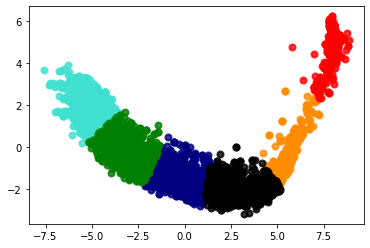

In [53]:
plt.figure()
target_names = [0,1,2,3,4, 5]

colors = ['navy', 'turquoise', 'darkorange','red','black', 'green']
lw = 2

for color, i, target_name in zip(colors, list(range(len(target_names))), target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)

In [54]:
for target_name in target_names:
    print(target_name, len(title[y==target_name]))
    print('\n'.join(title[y==target_name][:10]))
    print('')

0 888
【 曼谷 泰菜 學習 】 Silom Thai Cooking School 席隆 廚藝 課程
世界 唯一 的 你 ！ 韓國 大邱 歐洲 都市 公園 E-WORLD 樂園
【 羅馬 競技場 門票 】 羅馬 競技場 、 古羅馬 廣場 、 帕拉提諾 之 丘 （ 快速 通關 導覽 ）
【 韓國 冰雪 樂園 】 ONEMOUNT 水 上 樂園 / 冰雪 世界 （ 二 選 一 ） ＋ 水族館 、 Outlet
【 日本 三麗鷗 樂園 門票 】 東京 彩虹 樂園 、 九州 和諧 樂園 （ 二 選 一 ）
【 台中 熱門 景點 接駁 】 2018 臺中 世界 花卉 博覽會 門票 ＋ 去 程 接駁
【 體驗 巴黎 夜生活 】 夜遊 塞納河 、 紅 磨坊 歌舞秀
【 首 爾 近郊 特色 景點 】 原州 小 金山 懸索 吊橋 、 忠 州 Light World 一 日 遊
【 韓國 賞櫻 一 日 遊 】 韓國 鎮海賞日櫻 / 夜櫻 （ 釜山 出發 ）
【 韓國 冬季 限定 】 江 原 道平昌 鱒魚節 一日 遊 （ 首爾 出發 ）

1 1023
【 森林 裡 的 </UNK> 】 黃金海岸 藍 光 </UNK> 半 日遊
【 京都 一 日 遊 】 伏 見 稻荷 大社 、 清水寺 、 金閣寺 、 嵐山
【 北陸 秘境 】 此 生 必 去 日本 最 美 山岳 勝地 ・ 上 高地 一 日 遊
【 私人 小 團宿霧 出發 】 薄荷島 一 日 遊 、 巧克力山 探索 公園 （ 含 刺激 鋼索 單車 ）
【 墨寶 沙丁魚 風暴 】 巴 斯卡 多島 浮潛 、 嘉 華山 瀑布 一 日 遊 （ 宿霧 出發 ）
【 沖繩 必 買 票券 】 Okinawa Enjoy Pass 12 大 景點樂 遊 通票
【 全 紐約 最 便宜 】 紐約 尼加 拉大 瀑布 Niagara Falls 二 日 遊
【 台南 文青 小 旅行 】 深度 玩 台南 包車 一 日 遊
【 韓國 南怡島 一 日 遊 】 小 法國村 、 南怡島 、 江村 鐵路 自行車 （ 首爾 出發 ）
【 曼谷水 上 市場 一 日 遊 】 丹能莎朵 、 安帕瓦水 上 市場 、 樹中廟 、 美功 鐵道 市集 （ 保證 有位 ）

2 312
【 韓國 手機 租借 】 通話 SIM 卡 ＋ 上網 無 流量 限制 （ 仁川 機場 / 金浦 機場

HTML(value='<br><h3> Play with latent feature </h3> ')

FloatSlider(value=-1.1459346062308682, description='bin-0', max=15.492585674727687, min=-2.505448355265655)

FloatSlider(value=0.18544452105186307, description='bin-1', max=16.985741354562872, min=-10.218551585503882)

FloatSlider(value=0.10935357696551865, description='bin-2', max=16.55065280398624, min=-16.10252537742402)

FloatSlider(value=-1.449555410873142, description='bin-3', max=17.209029787384345, min=-5.831358691699588)

FloatSlider(value=-0.5006789131883659, description='bin-4', max=18.86475697696866, min=-9.117801530508219)

FloatSlider(value=-0.3343904804139407, description='bin-5', max=17.428554658245435, min=-9.836547563265324)

FloatSlider(value=0.9291275495961163, description='bin-6', max=22.11952880708638, min=-11.933126404039713)

FloatSlider(value=-1.749797414098167, description='bin-7', max=14.561279812024612, min=-14.46340701800207)

FloatSlider(value=-2.7306781962545994, description='bin-8', max=14.648870991234888, min=-9.521448554678706)

FloatSlider(value=1.8631313898973347, description='bin-9', max=15.797646888292546, min=-10.30682843554967)

FloatSlider(value=-2.3930286697600884, description='bin-10', max=13.121045220841836, min=-9.509098406339989)

FloatSlider(value=9.014090855635379, description='bin-11', max=22.800511515694488, min=-11.874670183202966)

FloatSlider(value=5.924824713945221, description='bin-12', max=11.411466476505565, min=-10.678222727543119)

FloatSlider(value=0.520219900165486, description='bin-13', max=16.576370891449276, min=-12.87550915591419)

FloatSlider(value=-0.09892492064259147, description='bin-14', max=13.498296300875742, min=-9.775896894246427)

FloatSlider(value=-1.4862626702597919, description='bin-15', max=15.43072014680294, min=-12.748411691460513)

FloatSlider(value=-0.999282652738437, description='bin-16', max=15.246294368463234, min=-11.208217345719968)

FloatSlider(value=0.4412534232347893, description='bin-17', max=27.243617786136706, min=-7.5497452920886055)

FloatSlider(value=-1.408317607965634, description='bin-18', max=22.70156204611232, min=-13.13339995350316)

FloatSlider(value=3.893719072508225, description='bin-19', max=18.240608421895416, min=-6.758710446310465)

In [23]:
print(init_latent)

[-1.14593461  0.18544452  0.10935358 -1.44955541 -0.50067891 -0.33439048
  0.92912755 -1.74979741 -2.7306782   1.86313139 -2.39302867  9.01409086
  5.92482471  0.5202199  -0.09892492 -1.48626267 -0.99928265  0.44125342
 -1.40831761  3.89371907]


In [1]:
import pickle
with open('latent_variable_20.pkl', 'rb') as f:
    latents = pickle.load(f)
print(latents[0])

[-0.40110661  0.053731    0.02041557 -0.49952886 -0.1492657  -0.04508191
  0.28627305 -0.60933987 -0.83062814  0.60365014 -0.14524659  2.80684088
  2.81072806  0.21474031 -0.14883904 -0.46788561 -0.35034584  0.2746236
 -0.19765725  1.58832746]


In [12]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

In [132]:
iter_ = 1000
with open(f'logs/vae_gumbel/cluster_{iter_}.pkl', 'rb') as f:
    clusters = pickle.load(f)

In [133]:
X, title = [], []
for key, latent in clusters.items():
    X.append(latent)
    title.append(key)
title = np.array(title)

In [134]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

No handles with labels found to put in legend.


explained variance ratio (first two components): [0.39433594 0.22087259]


Text(0.5, 1.0, 'PCA of clutser at 3000')

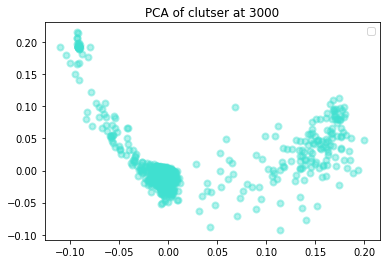

In [135]:
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
colors = ['navy', 'turquoise', 'darkorange']
lw = 2

plt.scatter(X_r[:, 0], X_r[:, 1], color='turquoise', alpha=.4, lw=lw)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of clutser at 3000')

In [136]:
from sklearn.cluster import DBSCAN
nbrs = DBSCAN(eps=3, min_samples=2).fit(X_r)
y = nbrs.labels_
print(set(y))

{0}


In [156]:
from sklearn.cluster import SpectralClustering
nbrs = SpectralClustering(n_clusters=6).fit(X_r)
y = nbrs.labels_
print(set(y))

{0, 1, 2, 3, 4, 5}


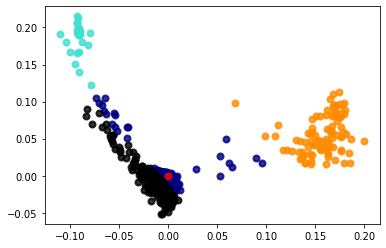

In [162]:
plt.figure()
target_names = [0,1,2,3,4]

colors = ['navy', 'turquoise', 'darkorange','red','black']
lw = 2

for color, i, target_name in zip(colors, list(range(len(target_names))), target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)

In [163]:
print(title[y==1][:30])

['【 官方 授權 】 ## ## ## ## ## ／ 快速 ## 通行票' '【 官方 授權 】 ## ## 手環 ## ## ## ##'
 '【 拉 報表 用 】' '【 官方 授權 】 ## ## 特快 入場券 （ 快速 通關 ## ## ） - 小小兵 3'
 '【 官方 授權 】 ## ## 電子 ## ＋ 環球 特快 入場券 （ 快速 通關 ## ## ） - 標準 7'
 '【 官方 授權 】 ## ## ™ ## ＋ 快速 ## 通關'
 '【 官方 授權 】 ## ## 特快 入場券 （ 快速 通關 ## ## ） - 歡樂 好 聲音 7'
 '【 官方 授權 】 豪華 套票 ： ## ## 電子 ## ＋ 豪華 特快 入場券 4 ## 小小兵 ) ＋ 豪華 5000 日幣 購物券'
 '【 官方 授權 】 ## ## 電子 ## ＋ ## 4 G 上網 推薦 ## 5 天 / 8 天 網卡 （ ## ## 取 件 ）'
 '【 官方 授權 】 ## ## ™ ## ＋ 特別版 快速 ## 通關'
 '【 官方 授權 】 ## ## 電子 ## ＋ 環球 特快 入場券 （ 快速 通關 ## ## ） - 標準 6'
 '【 官方 授權 】 ## ## ™ 快速 通關券 - 標準 4 ． 飛天 翼龍 4 ## 1 / 10 起 )'
 '【 城市 景點 隨 你 看 】 ## 觀光 巴士 一日券' '【 造訪 007 電影 場景 】 攀 牙 灣 、 ## ## 一 日 遊'
 '【 官方 接駁車 】 愛 寶 ## 、 ## 直達 接駁車 （ ## 出發 ）'
 '【 官方 授權 套票 】 ## ## ## ## ## ＋ ## ## ##'
 '【 水陸 兩棲 巴士 探索 之 旅 】 ## 城市 觀光 ＋ ## 遊船 體驗'
 '【 官方 授權 】 ## 夜間 ## ## （ ## ## ）' '【 官方 授權 】 ## ## ™ ## 盛夏 ## ##'
 '【 官方 授權 】 ## ## 電子 ## ＋ 環球 特快 入場券 （ 快速 通關 ## ## ） - 標準 4 （ 1 / 10 起 ）'
 '【 騎 機車 饗 美食 】 夜遊 順化 ##' '【 超人 氣 動畫 主題 巴士 】 你 的 名字 ・ 敞篷 咖啡 巴士'
 '【 官方 授權 】

In [164]:
print(title[y==0][:30])

['【 ## 頂級 按摩 】 經典 套餐 獨家 8 </UNK>' '【 ## 最 大 ## 】 </UNK> 時代 ## 主題 ## ##'
 '【 ## ## ## 】 ## 首 ## ## 快 線 ## 單程 車票'
 '【 ## ## 道 循環 巴士 】 臨 ## ## 、 第三 地道 、 都 ## ## 、 ## ## 、 ## ##'
 '【 ## 一 日 遊 】 元 乃 ## ## 、 ## 、 ## 弁 ## 一 日 遊 （ ## 出發 ）'
 '【 免 排隊 快捷 通道 】 三合一 套 票 ： ## 夫人 ## ## 摩天 ## ## 纜車'
 '【 ## 上網 電話卡 】 ## 7 天 ## 卡 500 分鐘 通話 （ ## ## 領取 ）'
 '【 ## 賞 花 一 日 遊 】 ## ## ## 粉蝶 花 之 丘 ・ ## ## 紫藤 花'
 '【 ## ## 露營 二 日 遊 】 ## 國家 ## 、 ## 、 ## ## （ ## 出發 ）'
 '【 超 划算 七 折 優惠 】 ## ## 快 綫 車票 （ ## ## 快速 入閘 ）'
 '【 ## ## 二 日 遊 】 ## ## 小 火車 ・ ## ## ## ・ ## 水壩 ## ## 出發 )'
 '【 ## 必 看 表演 】 ## 奇幻 大秀 ## ## ##' '【 專屬 ## 優質 接送 】 ## ## 包車 接送 （ 雙向 發車 ）'
 '【 ## 4 G 上網 推薦 】 ## 5 天 / 8 天 網卡 （ ## ## 取 件 ）'
 '【 ## 上下 顛倒 屋 】 超值 優惠 ##'
 '【 ## JR PASS 】 ## & ## ## 周遊券 ## （ ## ## 取 件 ）'
 '【 ## 出發 】 ## ## 8 折 優惠 車票 （ ## 限定 電子票 ）'
 '【 頂級 法式 自助餐 】 ## 十六 ## 海風 ## 自助餐' '沒有 ## 的 ## ！ ## ## ## 一 日 遊'
 '【 ## 必備 ## 票券 】 ## 八達通 交通卡' '【 ## ## 出發 】 ## 高鐵票 8 折 優惠 （ ## 限定 電子票 ）'
 '【 ## 鐵道 自行車 】 ## 鐵道 ## ## 電子 ##'
 '【 ## 純淨 ## 6 日遊 】 造訪 ## 最 美 冰川

In [165]:
print(title[y==2][:30])

['## 包車 一 日 遊 ． 暢遊 經典 ## 8 小時' '## 音樂劇 ## ． ##' '## ## 愛 3 ## ## ##'
 '63 ## ## － ## 藝術城 ##' '## 出發 ) ## 包車 一 日 遊' '## 夜間 意式 薄餅 遊船 之 旅'
 '## 愛 寶 ## 電子 ## （ ## ## ）' '## ## 自然 之 旅 1 日 遊'
 '專車 小包團 ) （ 5 天 4 夜 玩 轉 ## 特製 團 ）'
 '## 周遊卡 ## ## PASS 1日券 / 2日券 （ ## ## 取 件 ）' '## ## ## 盛事 ## 自助 午餐 ／ 晚餐'
 '## 包車 ． 探索 ## 的 秘密 半 日遊' '## ## 國家 ## 一 日 遊 （ ## ## ## 來回 ）'
 '## ． </UNK> 活 一 日 遊' '## ## 紫蝶 ## 精彩 一 日 遊'
 '## ## 8 ## － ## 神秘 小 ## ． 春天 ## 神奇' '## 經典 1 日 遊'
 '## 一日 包車 遊 ． 探訪 金車 城堡 ## ## 泡湯' '## 珍奶 ## ## 。 珍珠 奶茶 ## 手搖 體驗'
 '## ## 大 巴士 觀光 車票' '## ## 限定 ！ ## 鱒魚 冰釣 之 旅' '## ## ## ## 特快 列車 和 ## 套 票'
 '## ## 超值 冒險 之 旅 一 日 遊' '## ## ## ## ##' '## ， 越 夜 越 美麗 ！'
 '## 5 日 遊 ： ## 、 ## 、 酒杯灣 、 ## 、 ## 頓' '## ## ## 滑翔 傘 體驗'
 '## 鐵道 自行車 ## ##' '住宿 ## ## ・ 欣賞 ## 遺產 合掌屋 ＆ 飛驒 ## ＆ 上 高地 二 日 遊 ！'
 '## ## 美食 ## 蝦 ## 餐券']


In [166]:
print(title[y==3][:30])

['【 探訪 鐘樓 怪人 】 ## ## 大 ## ＋ 塔 頂 快速 通關票 ## 含 專人 導覽 )']


In [168]:
print(title[y==5][:30])

['巴士 一 日 ## ・ 美麗 海 ## ・ ## 海 的 魅力 （ 多 語言 語音 導覽 ）'
 '清境 ## 拼車 一 日 遊 （ 兩 人 成行 ， 一 人 起 訂 ）' '輕鬆 上下 清境 ## - 直達 共 乘車'
 '三麗鷗 彩虹 ## ##' '7 日 </UNK> ## ## ## “ 唯美 自然 ” 遊'
 '## 高原 ## 之 旅 ## 從 ## 出發 )'
 '春假 ## 文創 生態 一 日 遊 ## ## 行程 : ## 隧道 / 夕 遊 出張 所 / ## ## )'
 '## 直升機 飛行 、 奢華 午餐 和 雙體船海 ##' '首 ## 雙層 觀光 巴士 傳統 文化 路線'
 '酷 ## 滑雪 一 日 遊 ， ## / ## 出發' '一同 趣 郊遊 。 妖怪 、 ## 、 ##'
 '【 360 度 全 </UNK> 視覺 體驗 】 ## 長 ## </UNK> ## ##'
 '</UNK> 不可 錯過 ！ </UNK> 在 ## 的 ## 草莓 ##' '鐵道 ## 能 龍 ## ## ## 豐富 一 日 遊'
 '7593 （ 四 日 套餐 ）' '從 ## ： ## 瀑布 一 日 遊 與 品酒'
 '## 私人 包車 ・ 六 天 ## ## 包車 旅遊 ## ## ## / ## ## ## 上 下車 )'
 '幸福 ## ・ 戀 上 金針 花海 與 ## 泡湯 好 舒服' '## 威尼斯人 貢 ## 船票' '大 ## 深度 之 旅'
 '## 私人 包車 ・ 五 天 ## ## 包車 旅遊 ## ## ## / ## ## ## 上 下車 )'
 '## 租 車 自 駕遊 （ 附贈 保險 ）' '隨 上 隨 下 參觀 ## 巴士 之 旅' '## ： 1 小時 全 景 城市 旅遊 連 遊船'
 '## 限定 的 絕景 ， 去 看 藏王 樹冰 吧 ！ 享受 「 ## ## 之 湯 」 遊覽 藏王 溫泉街 （ ## 出發 二 日 遊 ）'
 '【 360 度 全 景 體驗 拼團 遊 】 ## 高塔 賞 美景 、 享用 下午茶'
 '「 愛 來 魔 相 4 ## ## 」 ## ## ## ##' '一 ## 海 之 星 ## ## ## ##'
 '一起 賞 花 趣 ！ ## ## 鬱金香 慶典 、 油菜 花田 、 草莓 #

In [6]:
import pickle

In [152]:
with open('data/kkday_dataset/matrix_factorized_64.pkl', 'rb') as f:
    mf = pickle.load(f)
generate_data = torch.load('gen_results.pt')

In [153]:
generate_data[0].keys()

dict_keys(['tgt', 'item_ids', 'user_ids', 'neg_ids', 'title', 'gen', 'gen_tokens'])

In [117]:
print(generate_data[0])

{'tmp': tensor([   2, 1624,  333,    5,  801, 1626,    5,    3,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0, 

In [118]:
invertid = { v:k for k, v in mf['name2id'].items()}

In [119]:
from dataset import KKDayUser, seq_collate
dataset =  KKDayUser(-1, 'data/kkday_dataset/user_data', 
            'data/kkday_dataset/matrix_factorized_64.pkl',
            prefix='item_graph', embedding=None, max_length=13, force_fix_len=False, 
            token_level='word', is_train=True)

In [120]:
dataset.prod2id

{'27759': 0,
 '24203': 1,
 '23019': 2,
 '2014': 3,
 '19425': 4,
 '19712': 5,
 '19983': 6,
 '8705': 7,
 '10062': 8,
 '3898': 9,
 '8070': 10,
 '1964': 11,
 '5250': 12,
 '19943': 13,
 '25035': 14,
 '13929': 15,
 '7812': 16,
 '10544': 17,
 '7733': 18,
 '5293': 19,
 '9861': 20,
 '22089': 21,
 '24880': 22,
 '20783': 23,
 '19153': 24,
 '22367': 25,
 '4068': 26,
 '18629': 27,
 '22898': 28,
 '22914': 29,
 '21258': 30,
 '4612': 31,
 '20650': 32,
 '22140': 33,
 '7444': 34,
 '18574': 35,
 '24857': 36,
 '25032': 37,
 '6946': 38,
 '9474': 39,
 '9824': 40,
 '25656': 41,
 '20785': 42,
 '21602': 43,
 '19723': 44,
 '9632': 45,
 '21491': 46,
 '20313': 47,
 '20497': 48,
 '19175': 49,
 '10729': 50,
 '22778': 51,
 '10262': 52,
 '21223': 53,
 '5763': 54,
 '13936': 55,
 '22456': 56,
 '22388': 57,
 '21240': 58,
 '19181': 59,
 '6622': 60,
 '9959': 61,
 '27852': 62,
 '20194': 63,
 '18951': 64,
 '18402': 65,
 '25066': 66,
 '17987': 67,
 '8829': 68,
 '18445': 69,
 '20300': 70,
 '25107': 71,
 '13358': 72,
 '18197':

In [169]:
from torch.utils.data import Dataset
from collections import defaultdict
from preprocess import clean_text, segment_text, pad_sequence
from constant import (
    CACHE_DIR, 
    MAX_LENGTH, Constants)
from tokenizer import CharTokenizer, WordTokenizer
import random

class MF_dataset(Dataset):
    
    def __init__(self, mf, generate_data, dataset, neg_size=100,token_level='word'):
        all_items = []
        bipartile = {}
        negative_items = {}
        
        self.vocab_size = dataset.vocab_size

        invertid = { value: key for key, value in dataset.user2id.items() }

        for key, value in dataset.prod2id.items():
            invertid[value] = key
            all_items.append(key)

        if token_level == 'word':
            tokenizer = WordTokenizer()
        else:
            tokenizer = CharTokenizer()
        self.invertid = invertid
        print('id_prod2title')
            
        id_prod2title = { invertid[int(data['item_ids'])] : data['tgt']  for data in generate_data }

        ## Create negative user samples
        print('create')
        for user, items in dataset.users_pid.items():
            negative_sample = []
            max_iter = 0
            while len(negative_sample) < neg_size:
                rand_idx = random.randint(0, len(all_items)-1)
                neg_i = all_items[ rand_idx ]
                if neg_i not in dataset.users_pid[user] and neg_i in id_prod2title:
                    negative_sample.append(  dataset.prod2id[neg_i]  )
                if max_iter > neg_size+10:
                    break
                max_iter += 1
            negative_items[dataset.user2id[user]] = negative_sample

        self.id_prod2title = id_prod2title
        self.negative_items = negative_items
        self.data = generate_data
        
    def __getitem__(self, item):
        row = self.data[item]
        tgt = row['tgt']
        gen = row['gen_tokens']
        neg_idx = random.choice(self.negative_items[ int(row['user_ids']) ])
        neg_title = self.id_prod2title[self.invertid[neg_idx]]
        return row['user_ids'], tgt, neg_title, gen

    def __len__(self):
        return len(self.data)

    
def mf_collate(batch):
    user_ids, tgt_, neg_tgt_, gen_tgt_ = [], [], [], []
    min_tgt = min([ s[1].shape[0] for s in batch ])
    min_neg = min([ s[2].shape[0] for s in batch ])
    min_gen = min([ s[3].shape[0] for s in batch ])
    for user_id, tgt, neg_tgt, gen in batch:
        user_ids.append(user_id)
        tgt_.append(tgt[:min_tgt])
        neg_tgt_.append(neg_tgt[:min_neg])
        gen_tgt_.append(gen[:min_gen])
    
    neg_tgt_ = torch.stack(neg_tgt_)
    gen_tgt_ = torch.stack(gen_tgt_)
    tgt_ = torch.stack(tgt_)
    user_ids = torch.stack(user_ids)
    
    return user_ids, tgt_, neg_tgt_, gen_tgt_
    


In [170]:
dataset_ = MF_dataset(mf, generate_data, dataset, neg_size=10)
dataloader = torch.utils.data.DataLoader(dataset_, batch_size=32, collate_fn=mf_collate)    

id_prod2title
create


In [171]:
for batch in dataloader:
    print(batch[2].shape)

torch.Size([32, 174])
torch.Size([32, 174])
torch.Size([32, 174])
torch.Size([32, 174])
torch.Size([32, 174])
torch.Size([32, 174])
torch.Size([32, 174])
torch.Size([32, 174])
torch.Size([32, 177])
torch.Size([32, 176])
torch.Size([32, 176])
torch.Size([32, 174])
torch.Size([32, 174])
torch.Size([32, 174])
torch.Size([32, 174])
torch.Size([32, 174])
torch.Size([32, 174])
torch.Size([32, 174])
torch.Size([32, 174])
torch.Size([32, 177])
torch.Size([32, 174])
torch.Size([32, 174])
torch.Size([32, 177])
torch.Size([32, 174])
torch.Size([32, 174])
torch.Size([32, 174])
torch.Size([32, 174])
torch.Size([32, 174])
torch.Size([32, 174])
torch.Size([32, 177])
torch.Size([32, 174])
torch.Size([32, 177])
torch.Size([32, 174])
torch.Size([32, 174])
torch.Size([32, 174])
torch.Size([32, 177])
torch.Size([32, 174])
torch.Size([32, 174])
torch.Size([32, 177])
torch.Size([32, 174])
torch.Size([32, 174])
torch.Size([32, 174])
torch.Size([32, 174])
torch.Size([32, 174])
torch.Size([32, 174])
torch.Size

In [148]:
class SimpleMF(nn.Module):
    
    def __init__(self, user_size, vocab_size, n_factors):
        super().__init__()
        self.user_factors = torch.nn.Embedding(user_size, 
                                               n_factors,
                                               sparse=True)
        # text encoder
        self.word_factors = torch.nn.Embedding(vocab_size, 
                                               n_factors,
                                               padding_idx=0)
    def forward(self, user, item):
        return (self.user_factors(user) * self.word_factors(item).mean(1)).sum(1)

In [149]:
simple_mf = SimpleMF(len(dataset.user2id), dataset_.vocab_size, 16)

simple_mf(torch.randint(0, 10, (32,)),  torch.randint(0, 10, (32, 10,)) )

torch.Size([32, 16])


tensor([ 1.0520,  1.1928, -0.7489,  4.0777,  0.1008, -0.7187,  1.4231,  0.1756,
         1.9577, -1.9736,  2.1636, -0.3215, -2.6001,  0.8379,  1.4993,  1.1153,
         1.0476, -0.4259, -0.5161,  0.3191,  0.8243,  0.5523,  1.6348,  1.0240,
        -0.5490,  3.0912,  1.7967,  4.3510,  0.2502, -0.4775, -2.8386, -1.9286],
       grad_fn=<SumBackward1>)

In [48]:
invertid = { v:k for k, v in mf['name2id'].items()}

In [50]:
invertid[2456]

'1d6b24c3-2bac-4915-b205-e4fd1661ef92'

In [61]:
with open('data/kkday_dataset/user_data/useritem_relations.txt', 'r') as f:
    for line in tqdm(f.readlines()):
        user_id, prod_id = line.strip().split('\t')
        if int(prod_id) == 2537:
            print('found')

/home/theblackcat102/Documents/text-subgan/env/lib/python3.6/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [6]:
log_name = 'save/tempest_mf-g2-2020-07-13-22-55-34'
checkpoint = 'checkpoint_99000.pt'

from module.vmt import VMT
with open(os.path.join(log_name, 'params.json'), 'r') as f:
    params = json.load(f)
args = Struct(**params)
id_mapping = torch.load(os.path.join(args.cache_path, 'id_mapping.pt'))
user_size = len(id_mapping['user2id'])
user_size = user_size
prod_size = len(id_mapping['prod2id'])


model = VMT(args.gen_embed_dim, args.vocab_size,
            enc_hidden_size=500, dec_hidden_size=500, tmp_category=args.tmp_cat_dim,
            tmp_latent_dim=args.tmp_latent_dim, desc_latent_dim=args.desc_latent_dim, user_latent_dim=args.user_latent_dim,
            biset=args.biset, user_embedding=True, user_size=user_size,
            max_seq_len=args.max_seq_len-1, gpu=True).cuda()
model.load_state_dict(torch.load(os.path.join(log_name,checkpoint))['model'])

id2user = { value: key for key, value in id_mapping['user2id'].items() }


In [7]:
id2user = { value: key for key, value in id_mapping['user2id'].items() }

In [8]:
from dataset import TemPest, tempest_collate
valid_dataset = TemPest(args.cache_path, 'valid')
eval_dataloader = torch.utils.data.DataLoader(valid_dataset, num_workers=8,
                        collate_fn=tempest_collate, batch_size=20, shuffle=False, drop_last=True)

dataset/valid.pt


In [9]:
print(len(valid_dataset))

1761


In [10]:
sentences, references = [], []
temp_latent = []
with torch.no_grad():
    for batch in tqdm(eval_dataloader):
        src_inputs = batch['src']
        tmp = batch['tmt']
        inputs, target = batch['tgt'][:, :-1], batch['tgt'][:, 1:]
        users = batch['users']
        empty_users = users == -1
        batch_size = len(empty_users)
        users_filled = users.detach()
        users_filled[empty_users] = torch.randint(0, user_size, ( int(empty_users.sum()),  ))

        if cfg.CUDA:
            src_inputs = src_inputs.cuda()
            target = target.cuda()
            tmp = tmp.cuda()
            inputs = inputs.cuda()
            users_filled = users_filled.cuda()

        desc_outputs, desc_latent, desc_mean, desc_std = model.encode_desc(src_inputs)
        tmp_outputs, tmp_latent = model.encode_tmp(tmp)
        for latent_ in tmp_latent:
            temp_latent.append(latent_.cpu().numpy().flatten())
        user_embeddings = model.user_embedding( users_filled )
        _, output_title = model.decode(tmp_latent, desc_latent, user_embeddings, 
                desc_outputs, tmp_outputs,
                max_length=target.shape[1])

        for idx, sent_token in enumerate(batch['tgt'][:, 1:]):
            reference = []
            for token in sent_token:
                if token.item() == Constants.EOS:
                    break
                reference.append(valid_dataset.tokenizer.idx2word[token.item()] )
            references.append(''.join(reference))

            sent = output_title[idx]
            sentence = []
            for token in sent:
                if token.item() == Constants.EOS:
                    break
                sentence.append(valid_dataset.tokenizer.idx2word[token.item()])
            sentences.append(''.join(sentence))

/home/theblackcat102/Documents/text-subgan/env/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


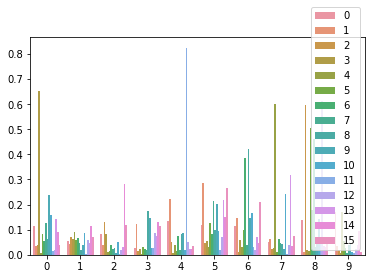

In [13]:
data = {'y': [], 'bins': [], 'type': []}
for idx, latent in enumerate(X[0].reshape(args.tmp_latent_dim, args.tmp_cat_dim)):
    data['y'] += list(range(len(latent)))
    data['bins'] += list(latent)
    data['type'] += list([idx]*len(latent))
sns.barplot(x='y', y='bins', data=data, hue='type')

In [14]:
with torch.no_grad():
    for batch in tqdm(eval_dataloader):
        src_inputs = batch['src']
        tmp = batch['tmt']
        inputs, target = batch['tgt'][:, :-1], batch['tgt'][:, 1:]
        users = batch['users']
        non_empty_users = users != -1
        if cfg.CUDA:
            src_inputs = src_inputs[non_empty_users].cuda()
            target = target[non_empty_users].cuda()
            tmp = tmp[non_empty_users].cuda()
            inputs = inputs[non_empty_users].cuda()
            users = users[non_empty_users].cuda()

        if non_empty_users.sum() > 0:
            print('found')
            break

/home/theblackcat102/Documents/text-subgan/env/lib/python3.6/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


found


In [15]:
cnt = 0
with torch.no_grad():
    for batch in tqdm(eval_dataloader):
        cnt += 1
        users2 = batch['users']
        non_empty_users = users2 != -1
        if cfg.CUDA:
            users2 = users2[non_empty_users].cuda()
        if non_empty_users.sum() > 0 and cnt > 10:
            print('found')
            break

/home/theblackcat102/Documents/text-subgan/env/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


found


In [16]:
print(users.shape, users2.shape)

torch.Size([6]) torch.Size([10])


In [17]:
desc_outputs, desc_latent, desc_mean, desc_std = model.encode_desc(src_inputs)
tmp_outputs, tmp_latent = model.encode_tmp(tmp)
user_embeddings = model.user_embedding( users )
_, output_title = model.decode(tmp_latent, desc_latent, user_embeddings, 
        desc_outputs, tmp_outputs,
        max_length=target.shape[1])
for idx, sent in enumerate(output_title.cpu()):
    sentence = []
    for token in sent:
        if token.item() == Constants.EOS:
            break
        sentence.append(valid_dataset.tokenizer.idx2word[token.item()])
    print("{:<40} | {:>}".format('user: '+ id2user[users[idx].item()], ''.join(sentence[:50]).strip(),  ))

user: 9bdb07d2-83c2-4387-8270-dae6ece6712c | 【東京人氣主題樂園】2019紅木東京門票門票展望台＋HARUKAS鐵路
user: 149bbfbe-439a-4a57-b196-0cfcc703ff8a | 【熱門景點包車一日遊】華泰老街、鯉魚潭漁港、東海道宮原眼科中商圈（台北出發台北
user: 6cd0e7e4-3729-4f49-a405-d3dd9e343df2 | 【北海體驗】】】紅樹林獨木舟、搭乘竹筏、體驗蠟染（含馬來午餐）
user: 4e3adca1-8f3b-46ba-ab81-c8117a1abdc1 | 【東京知名邊】布塞東京、三輪車林道巡航（附午餐）
user: 9a0eb24e-1995-496c-9a85-466669deed52 | 【胡志明市特色風情】胡志明市區地道半日遊
user: 1df97957-9714-45c3-bf7f-355066330481 | 【上海繽紛大】】】私廚包場・K-POP經典


In [18]:
user2_embeddings = model.user_embedding( users2[:6,] )
_, output_title = model.decode(
        tmp_latent,
        #control_latent[:6].cuda(), 
        desc_latent, user2_embeddings, 
        desc_outputs, tmp_outputs,
        max_length=target.shape[1])
for idx, sent in enumerate(output_title):
    sentence = []
    for token in sent:
        if token.item() == Constants.EOS:
            break
        sentence.append(valid_dataset.tokenizer.idx2word[token.item()])
    print("{:<40} | {:>}".format('user: '+ id2user[users2[idx].item()] , ''.join(sentence[:50]).strip(), ))

user: 512a0cd9-a5da-4e06-8719-ba1beb318f22 | 【東京人氣主題樂園】2019Rail世界＋太展望台＋二日券
user: d71fa448-6d07-4edb-978e-b7e3f70b5884 | 【熱門景點包車一日遊】華泰老街、鯉魚潭漁港、鎮瀾宮道、一草商圈（台北出發台北
user: 72626a27-8758-4391-af6f-928fedb0c713 | 【北海體驗藍夢島】猴子紅樹林獨木舟體驗（竹筏浮潛）海釣午餐（馬來午餐）
user: 2f09fcc0-dbcd-45ff-92b6-8d67460ca0f1 | 【東京知名楓葉】布塞東京、三輪車、大原沙龍照展望台所
user: daa12bd2-fb26-4ce2-b12b-788ed6de84fd | 【胡志明市特色景點】胡志明市區地道半日遊
user: 30ed0e8e-a67e-493a-b52e-951fc50c79a1 | 【上海音樂建築】】城市祭》多日遊


In [120]:
latent_dim = args.tmp_latent_dim
categorical_dim = args.tmp_cat_dim
M =  args.tmp_cat_dim * args.tmp_latent_dim
np_y = np.zeros((M, categorical_dim), dtype=np.float32)
np_y[range(M), np.random.choice(categorical_dim, M)] = 1
np_y = np.reshape(np_y, [ M // latent_dim, latent_dim, categorical_dim])[:6, :,:]

In [121]:
random_sample = torch.from_numpy(np_y).view(6, latent_dim * categorical_dim).cuda()
_, output_title = model.decode(
        random_sample,
        #control_latent[:6].cuda(), 
        desc_latent, user_embeddings, 
        desc_outputs, tmp_outputs,
        max_length=target.shape[1])
for idx, sent in enumerate(output_title):
    sentence = []
    for token in sent:
        if token.item() == Constants.EOS:
            break
        sentence.append(valid_dataset.tokenizer.idx2word[token.item()])
    print("{:<40} | {:>}".format('user: '+ id2user[users2[idx].item()] , ''.join(sentence[:50]).strip(), ))

user: 60abff64-dd9c-4709-97e8-421c042b172e | 【東京玩樂】】草莓古街啤酒太門票門票門票＋纜車門票
user: 9f99b482-7f92-44d6-8d37-a6ce2ebb361a | 【熱門景點包車一日遊】華泰老街、鯉魚潭、、鎮瀾宮道、一紅谷商圈（台北出發台北結束台中結束）
user: a63326f5-4abf-4de1-89fb-57353ed84a1e | 【沖繩獨特體驗】紅樹林集集壁畫村浮潛體驗（竹筏）體驗、（含馬來）
user: 9f686463-8657-4765-b11a-72c8ab25c56d | 【東京】】富士宮遊船】2019嵐山、大原白空中所
user: ea0e5344-d434-46af-bb86-d1f8699ed9af | 【法國特色風情】胡志明市一地道半日遊
user: 30ed0e8e-a67e-493a-b52e-951fc50c79a1 | 【上海音樂經典】】跳廣場入場


In [92]:
no_bracket_sample = X[y==0][[0, 8, 15,14, 12,17]]
no_bracket_sample = torch.from_numpy(no_bracket_sample).view(6, latent_dim * categorical_dim).cuda()

templates = title[y==0][[0, 8, 15,14, 12,17]]

_, output_title = model.decode(
        no_bracket_sample,
        desc_latent, user2_embeddings, 
        desc_outputs, tmp_outputs,
        max_length=target.shape[1])

for idx, sent in enumerate(output_title):
    sentence = []
    for token in sent:
        if token.item() == Constants.EOS:
            break
        sentence.append(valid_dataset.tokenizer.idx2word[token.item()])
    print(templates[idx])
    print("{:<40} | {:>}".format('user: '+ id2user[users2[idx].item()] , ''.join(sentence[:50]).strip(), ))

巴耶內瓦多和Cousiño馬庫爾：從聖地亞哥一日遊
user: 9217fc8b-7c4a-469b-97d2-b383c98da6c0 | 【東京必去】【本美術館門票＋主題館票
復古的菲亞特500汽車前往基安蒂村莊進行1日自駕遊
user: 0b08ae06-5b26-4ece-8857-6fd774078e93 | 【熱門景點包車一日遊】鶯歌名品城、峨眉湖、、審計、宮原眼科濕地台北（台北出發、台中台中）
香港IvanTheKozak餐廳餐券
user: 24b84430-7fe0-4289-aff0-793e086bf6ee | 【體驗生態體驗】天然生態之旅、搭乘竹筏、體驗蠟染體驗
專屬行程：蘭卡威雨林徒步探險
user: 1f7ccc8a-0bb6-4375-96b9-d9b19d783cc2 | 【東京巴士半】】】賞櫻・大倉山星光峽、・島/晚餐
冒險港主題公園和法拉利樂園的門票
user: daa12bd2-fb26-4ce2-b12b-788ed6de84fd | 【胡志明市特色導覽】遊市區地道古芝導覽越戰市區導覽遊＋英語導遊）
【北越山城故事】梯田間的少數民族-</UNK>山谷一日遊
user: 30ed0e8e-a67e-493a-b52e-951fc50c79a1 | 【新加坡道地】】信・武則天Foot家套餐創意


In [38]:
from sklearn.decomposition import SparsePCA
X, title = [], []

print(len(temp_latent))
for idx, latent in enumerate(temp_latent):
    X.append(latent)
    title.append(references[idx])

title = np.array(title)

X = np.array(X)

pca = SparsePCA(n_components=2)

X_r = pca.fit(X).transform(X)

nbrs = SpectralClustering(n_clusters=4).fit(X_r)

y = nbrs.labels_
print(set(y))

1760
{0, 1, 2, 3}


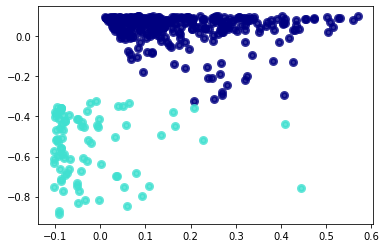

In [39]:
plt.figure()
target_names = [0,1]

colors = ['navy', 'turquoise']
lw = 3

for color, i, target_name in zip(colors, list(range(len(target_names))), target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)

In [124]:
print(title[y==0][:60])

['倫敦和哈利·波特場景私人半日遊' '【東京夜景】六本木之丘展望台門票（TokyoCityView）森美術館'
 '巴耶內瓦多和Cousiño馬庫爾：從聖地亞哥一日遊' '【東京賞櫻推薦】隅田川賞櫻遊船票（附賞花便當或點心）'
 '【名古屋出發一人成行】閃耀冬季！名花之里．冬季霓虹燈秀，還有午餐甜點吃到飽' '組合：在</UNK>和觀光游到伊瓜蘇瀑布'
 '【澳門美獅美高梅酒店】</UNK>・JaniceWongMGM午餐套餐/下午茶套餐'
 "阿姆斯特丹：A'DAM瞭望臺和OvertheEdge鞦韆票" '【北投人氣溫泉】北投麗禧溫泉雙人湯屋＋雙人下午茶'
 '【艾菲爾鐵塔快速入場】巴黎艾菲爾鐵塔快速入場與塞納河遊船' '【普吉唯一友善大象營】親密互動半日體驗'
 '【中國安徽文化歷史景點】呈</UNK>門票' '【騎單車遊曼谷】泰好吃！街頭美食饕客團' '【超值沙巴跳島】沙比島和馬穆迪島一日遊'
 '【Discovery探索基地】' '小琉球好玩。珊瑚礁島嶼風光' '【熱門景點包車一日遊】鶯歌老街、新豐紅樹林、彩虹眷村、秋紅谷（台北出發）'
 '米蘭：斯卡拉博物館與劇院旅遊' '【首爾人氣美食餐廳】</UNK>家黑豬肉專賣店' '【法式浪漫極致】艾菲爾鐵塔晚宴、塞納河遊船'
 '女性限定一人行！一次遊走日本香川、岡山、德島三縣市美術館充滿藝術氣質二日遊！' '【騎單車遊曼谷】早安曼谷單車之旅'
 '【小團划算】桃園機場臺北市區接機服務（七人座）' '日月潭山光水色豐富一日遊' '3天2夜親子遊'
 '【馬來西亞．動物探索之旅】大象保育中心與鹿島公園'
 '【2016</UNK>攝影】可可</UNK>．柴達木．</UNK>．越野9日行攝之旅（專業攝影師帶隊）'
 '【到海底看珊瑚礁】墾丁後壁湖半潛艇航程' '紐倫堡舊城與全</UNK></UNK>會場徒步行' '巴哈吉普車遊覽聖地亞哥洛斯卡沃斯：驅動器或騎'
 '妓院、美食與豪飲:聖地亞哥瓦斯</UNK>徒步遊' '柏林歡迎卡：交通、優惠和旅遊指南書'
 '【跟著專業導遊輕鬆</UNK>】360大嶼山海陸導賞團' '【飆速快感】韓國濟州島城邑樂園卡丁車體驗'
 '【薄荷島遊船午餐】羅伯克河遊船午餐私人包車)' '【奢華探險】愛寶樂園野生動物世界頂級SpecialTour'
 '【大城遊船一日遊】沿著昭披耶河欣賞世

In [125]:
tmp_latent = X[y==1].mean(axis=0)

In [126]:
control_latent = torch.stack([torch.from_numpy(tmp_latent)]*10)

In [127]:
print(title[y==1][:60])

['漢堡喜劇之旅' '【仙本那紅樹林】探索長鼻猴與螢火蟲半日遊' '【胡志明市特色一日遊】古芝地道、胡志明市區觀光導覽'
 '墾丁高雄零阻礙輕鬆包車接駁' '《沖繩景點通行票》精選熱門景點＋</UNK>水族館' '卡門浮潛和廢墟探險'
 '【新加坡郊野深度遊】烏敏島紅樹林獨木舟探險' '【經典花蓮必遊】太魯閣奇景拼車一日遊（保證有位）' '</UNK>海縱走生態行'
 '【360度全</UNK>視覺體驗】珠海長</UNK>琴島劇院' '攀登雪梨海港大橋'
 '【綠島二日遊】機車環島、夜訪梅花鹿與螢火蟲、夜間觀星（台北出發）' '葡萄牧場：瓦豪河谷酒莊自行車之旅'
 '豪華</UNK>馬斯美食之旅從麥德林' '【7-16座專車】大叻-美奈單程租車' '【Disneyland】加州迪士尼樂園優惠一日券'
 '【首爾人氣美食】大砲燉雞大學路店' '【荷蘭最美小鎮】羊角村小團悠閒一日遊阿姆斯特丹出發)' '【品味獨到】拉斯維加斯滑稽古怪秀</UNK>'
 '【失落之城】哥倫比亞八日探險之旅（含GoPro）' '【暢遊新加坡】最猛通行證！一卡在手玩遍城市各大景！'
 '【JRPASS】東日本・南北海道鐵路周遊券（香港取票點自取）' '台北出發。大溪嘎色鬧部落-開心農場' '祕魯</UNK>暨午餐或開放式酒吧'
 '【沙巴泛舟】九魯河激流泛舟體驗（亞庇出發）' '【九州租車】Budget．5人座S級客車' '【台灣經典北海岸】基隆和平島廟口夜市包車一日遊'
 '布宜諾斯艾利斯市遊覽與豪華午餐' '聖奧古斯丁觀光電車</UNK>，探訪100個多個名勝古蹟' '巴黎：隨上隨下大巴連塞納河遊船'
 '</UNK>。Huyliche遊覽的沙灘車' '【東京路跑體驗】挑戰一圈5K的路跑聖地—皇居！'
 '【</UNK></UNK></UNK>時尚派對】變裝＋餐飲體驗' '電動生態自行車海灘冒險' '沙巴市區半日走透透' '</UNK>全天遊'
 '【愛侶遊香港首選】天際100觀景台門票＋Vista英式下午茶雙人套票（電子票）' '【戀戀韓國】首爾城市風情走在時尚尖端的半日遊'
 '【權力的遊戲】走訪冰與火之歌鐵群島貝爾法斯特往返)' '【紐西蘭企鵝歸巢奇景】</UNK>企鵝保育中心門票'
 '【濟州人氣景點一日遊】牛島＋ECOLAND森林小火車生態公園＋早晨微笑牧場冰淇淋製作體驗' '溫

In [29]:
print(title[y==0][:10])

['【Disneyland】美國加州迪士尼樂園門票（電子一日券）' '【東京夜景】六本木之丘展望台門票（TokyoCityView）森美術館'
 '【龍尾灣生態體驗】搭竹筏＋抓螃蟹＋做蠟染（含馬來午餐）' '【仙本那紅樹林】探索長鼻猴與螢火蟲半日遊'
 '【東京賞櫻推薦】隅田川賞櫻遊船票（附賞花便當或點心）' '【胡志明市特色一日遊】古芝地道、胡志明市區觀光導覽'
 '【澳門美獅美高梅酒店】</UNK>・JaniceWongMGM午餐套餐/下午茶套餐' '【普吉唯一友善大象營】親密互動半日體驗'
 '【日本傳統文化】搭屋形船觀賞長</UNK>魚・泡溫泉品嚐</UNK>料理大阪出發)' '【到海底看珊瑚礁】墾丁後壁湖半潛艇航程']


In [44]:
print(title[y==2][:10])

['【柬埔寨最受矚目劇團】法爾，柬埔寨馬戲團Phare,theCambodiaCircus' '雅典城市通票：免費入場和免費遊覽'
 '伊瓜蘇生物中心參觀' '在日落時分騎馬，體驗西部荒原的牛仔生活' '斯德哥爾摩隨上隨下觀光巴士與小船旅遊'
 '聖薩爾瓦多：5小時中轉城市與火山之旅' '曼哈頓島豪華直升機旅遊' '波士頓的歷史之路®徒步遊' '布魯塞爾：布魯日一日旅遊連4小時導覽徒步遊'
 '柏林：1小時馬車夜遊柏林']


In [31]:
print(title[y==3][:10])

['【熱門景點包車一日遊】石門水庫、鎮瀾宮、台中麗寶Outlet（台北出發、台中結束）' '【中文導覽】馬來西亞機場市區優質接送（含WiFi熱點）'
 '【名古屋出發一人成行】閃耀冬季！名花之里．冬季霓虹燈秀，還有午餐甜點吃到飽' '【超值沙巴跳島】沙比島和馬穆迪島一日遊'
 '【經典花蓮必遊】太魯閣奇景拼車一日遊（保證有位）' '【熱門景點包車一日遊】鶯歌老街、新豐紅樹林、彩虹眷村、秋紅谷（台北出發）'
 '自採超甜草莓・螃蟹吃到飽＆滑雪場玩雪東京出發)' '女性限定一人行！一次遊走日本香川、岡山、德島三縣市美術館充滿藝術氣質二日遊！'
 '【小團划算】桃園機場臺北市區接機服務（七人座）' '【乘船遊小金門秘境】船遊戰地史蹟烈嶼7島（</UNK>碼頭出發）']


In [61]:
assert os.path.exists(os.path.join(log_name, 'vmt.py')) == True
print(os.path.join(log_name, checkpoint_name))
assert os.path.exists(os.path.join(log_name, checkpoint_name)) == True

copyfile(os.path.join(log_name, 'vmt.py'), 'module/temp_vmt.py')
checkpoint = torch.load(os.path.join(log_name, checkpoint_name))

from module.temp_vmt import VMT, TemplateD

# checkpoint should contain model state dict,
with open(os.path.join(log_name, 'params.json'), 'r') as f:
    params = json.load(f)
args = Struct(**params)
dataset =  KKDayUser(-1, 'data/kkday_dataset/user_data', 
            'data/kkday_dataset/matrix_factorized_64.pkl',
            prefix='item_graph', embedding=None, max_length=args.max_seq_len, force_fix_len=args.grad_penalty or args.full_text, 
            token_level=args.tokenize, is_train=True)
dataloader = torch.utils.data.DataLoader(dataset, num_workers=4,
                collate_fn=seq_collate, batch_size=64, shuffle=True)
model = VMT(args.gen_embed_dim, dataset.vocab_size,
            enc_hidden_size=128, dec_hidden_size=128, tmp_category=args.tmp_cat_dim,
            tmp_latent_dim=args.tmp_latent_dim, desc_latent_dim=args.desc_latent_dim, user_latent_dim=args.user_latent_dim,
            biset=args.biset,
            max_seq_len=args.max_seq_len-1, gpu=True)

C = VAE_Cluster(64, 64, k_bins=10, output_embed_dim=args.user_latent_dim)

model.load_state_dict(checkpoint['model'])
model = model.cuda().eval()
C = C.cuda().eval()
print(len(dataloader))

save/temp_temp_rec_vae_gan_biset-2020-05-15-16-34-59/amp_checkpoint_80000.pt
3486


In [57]:
template_reference = {}
size = 15000

for i, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
    src_inputs = batch['src']
    tmp = batch['tmp']
    items, users = batch['items'], batch['users']
    inputs, target1 = batch['tgt'][:, :-1], batch['tgt'][:, 1:]
    references = []
    if True:
        inputs, items, users = inputs.cuda(), items.cuda(), users.cuda()
        src_inputs = src_inputs.cuda()
        inputs = inputs.cuda()
        target1 = target1.cuda()
        tmp = tmp.cuda()

    batch_size = src_inputs.shape[0]
#     logits, embed = self.C(items, users)
    desc_outputs, desc_latent, _, _ = model.encode_desc(src_inputs)
    tmp_outputs, tmp_latent = model.encode_tmp(tmp)
#     _, output_title = self.model.decode(tmp_latent, desc_latent, embed,
#             desc_outputs, tmp_outputs,
#             max_length=self.args.max_seq_len)

    # output_title = torch.argmax(output_logits, dim=-1)
    for idx, sent_token in enumerate(batch['tgt'][:, 1:]):
        reference = []
        for token in sent_token:
            if token.item() == Constants.EOS:
                break
            reference.append(dataset.idx2word[token.item()] )
        references.append(reference)
    
    for idx, sent in enumerate(references):
        template_reference[' '.join(sent)] = {
            'tmp': tmp_latent[idx].detach().cpu().numpy(),
            'tmp_outputs': tmp_outputs[idx].detach().cpu(),
            'desc_latent': desc_latent[idx].detach().cpu(),
            'desc_outputs': desc_outputs[idx].detach().cpu(),
        }


/home/theblackcat102/Documents/text-subgan/env/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


KeyboardInterrupt: 